# Movie Recommendation Engine

In this notebook, we build a simple Movie Recommendation Engine based on [MovieLens Dataset](https://grouplens.org/datasets/movielens/latest/). 

We'll **only use the ratings** as the data for our Machine Learning algorithm.

<img src='assets/before_sunrise.png'>


## What we are trying to do:

<img src='assets/problem_setup.png'>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from surprise import Reader, Dataset
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.manifold import TSNE

## 1. Prepare Data

In [3]:
DATA_DIR = 'data/ml-latest-small/'

In [4]:
os.listdir(DATA_DIR)

['ratings.csv', 'README.txt', 'links.csv', 'tags.csv', 'movies.csv']

In [5]:
ratings_df = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), usecols=['userId', 'movieId', 'rating'])
ratings_df.shape

(100836, 3)

In [6]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
movies_df = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'))

In [8]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
rmdf = pd.merge(ratings_df, movies_df, on='movieId', how='left')
rmdf.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [10]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(rmdf[['userId', 'movieId', 'rating']], reader)

In [11]:
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

## 2. Train model

In [12]:
algo = SVD(n_factors=200, random_state=42)

In [13]:
algo.fit(trainset)

## 3. Test Model

In [14]:
test_pred = algo.test(testset)

accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8854


0.8853577370736795

## 4. Use Model (Make Predictions)

We can predict how much a user will like a movie and then sort the movies that user hasn't watched according to that score to get the top picks for the user. 

<img src='assets/score_to_rank.png'>

<img src='assets/top_picks.png'>

In [15]:
user_id = 1
user_movies = rmdf.query(f'userId == {user_id}')

In [16]:
user_movies.sort_values(by='rating', ascending=False).head(10)

,userId,movieId,rating,title,genres
231,1,5060,5.0,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
185,1,2872,5.0,Excalibur (1981),Adventure|Fantasy
89,1,1291,5.0,Indiana Jones and the Last Crusade (1989),Action|Adventure
90,1,1298,5.0,Pink Floyd: The Wall (1982),Drama|Musical
190,1,2948,5.0,From Russia with Love (1963),Action|Adventure|Thriller
189,1,2947,5.0,Goldfinger (1964),Action|Adventure|Thriller
188,1,2944,5.0,"Dirty Dozen, The (1967)",Action|Drama|War
186,1,2899,5.0,Gulliver's Travels (1939),Adventure|Animation|Children
184,1,2858,5.0,American Beauty (1999),Drama|Romance
179,1,2700,5.0,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical


In [17]:
unwatched_movies = [m for m in ratings_df['movieId'].unique() if m not in user_movies['movieId'].unique()]
scores = []
for m in unwatched_movies:
    score = algo.predict(user_id, m).est
    scores.append((m, score))

In [18]:
sdf = pd.DataFrame(scores, columns=['movieId', 'Score'])
sdf = sdf.merge(movies_df, on='movieId', how='left')
sdf.sort_values(by='Score', ascending=False).head(10)

,movieId,Score,title,genres
493,1246,5.236219,Dead Poets Society (1989),Drama
2275,306,5.190022,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
4054,7371,5.136067,Dogville (2003),Drama|Mystery|Thriller
150,2019,5.091345,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
1843,1217,5.067840,Ran (1985),Drama|War
1805,1952,5.053926,Midnight Cowboy (1969),Drama
496,1682,5.048391,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
191,3508,5.046774,"Outlaw Josey Wales, The (1976)",Action|Adventure|Drama|Thriller|Western
813,6502,5.043824,28 Days Later (2002),Action|Horror|Sci-Fi
532,5952,5.042124,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy


## Visualization (Extra)

In [19]:
popular_50_movie_ids = rmdf.groupby(by='movieId')['rating'].count().sort_values(ascending=False).head(50).index
popular_50_iids = []
for movie_id in popular_50_movie_ids:
    popular_50_iids.append(trainset.to_inner_iid(movie_id))
    
df_50 = pd.DataFrame({'movieId': popular_50_movie_ids})
df_50 = pd.merge(df_50, movies_df, on='movieId', how='left')

In [20]:
movie_embeddings = algo.qi[popular_50_iids]
movie_embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(movie_embeddings)

Note: Visualization adapted from [this notebook](https://hodapple.com/blag/posts/2018-04-08-recommender-systems-1.html).

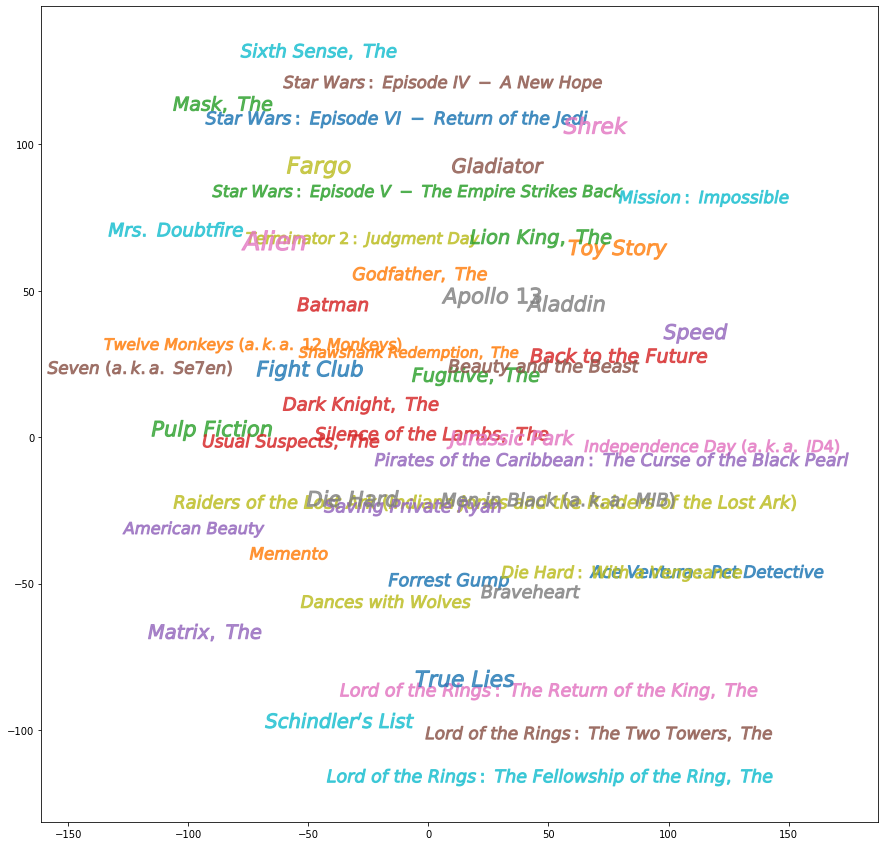

In [21]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in df_50["title"]]
for i, item in enumerate(movie_embeddings_2d):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker=markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

## Epilogue

Again, to emphasize, this only used the ratings (interaction data) from the users. Nothing directly about the movies themselves. That's the power of data!